# Projeto - Previsão de receita

## Contexto:

**O contexto não foi definido**. Entretanto, para contextualizar o projeto **estarei adotando a seguinte abordagem:**

**Contexto:** Uma empresa chamada QualityShoes opera no ramo de e-commerce dentro da área de artigos esportivos. Como a empresa ainda não tem um time de dados estruturado, ela fez um contrato com uma empresa de consultoria especializada no ramo de transformação digital. Nesse sentido, após uma primeira reunião com o CFO da quality, a empresa de consultoria constatou que o primeiro projeto a ser realizado deveria ser a projeção de receita líquida. O portfólio da quality é bem amplo, com mais de 100 mil clientes atacadistas e varejistas. A ideia inicial do projeto é entender as principais variáveis que estão correlacionadas à receita e retirar insights importantes para o time de negócio.

## Objetivo de negócio:

* Projeção de receita para os próximos 6 meses

## Entendimento do negócio:

1. Qual a motivação:
    * A projeção de receita nos próximos 6 meses surgiu a partir da necessidade de entender qual o melhor budget para investimentos na empresa e também entender quais seriam as áreas que deveriam ter um melhor investimento.


2. Qual a causa raíz do problema:
    * Dificuldade em determinar o melhor budget para investimentos internos


3. Quem é o dono do problema:
    * Diretor financeiro (CFO) da QualityShoes


4. Qual é o formato da solução?
    * **Granularidade:** Previsão de receita nos próximos 6 meses
    * **Tipo de problema:** Previsão de receita (Regressão)
    * **Potenciais métodos:** Séries temporais e regressão com algumas modificações
    * **Formato de entrega:**
        * O valor total da receita líquida no final dos 6 meses.
        * A entrega será pelo app do streamlit
        * Checagem trimestral


# 0.0 Imports

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import pathlib




from IPython.core.display  import HTML
from IPython.display       import Image


In [65]:
import warnings
warnings.filterwarnings("ignore")

## 0.1 Helper Functions

In [66]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

In [46]:
def _extract_letter(text):
    text = re.sub('[A-Z]','',text)
    return text


## 0.2 Variables path

In [77]:
PATH_ROOT = pathlib.Path('..').resolve()
DATA_ROOT = os.path.join(PATH_ROOT,'data')
DATA_RAW = os.path.join(DATA_ROOT,'raw')
DATA_PREPROCESSED = os.path.join(DATA_RAW, 'preprocessed')

DOC_ROOT = os.path.join(PATH_ROOT, 'doc')
IMAGE_PATH = os.path.join(DOC_ROOT,'image')
# File data
_data_raw = os.path.join(DATA_RAW, 'Dataset_teste_Just_BI.csv')
_image_map_hypothesis = os.path.join(IMAGE_PATH,'Forescast_Net_Revenue.png')


## 0.3 Data Loading

In [19]:
df = pd.read_csv(_data_raw, sep=';')

# 1.0 Data Description

In [20]:
df1 = df.copy()

In [21]:
df1.head()

,customer_id,customer_acquisition_channel,year,week,net_revenue,gross_revenue,boxes
0,206461,Paid Marketing,2014,W09,71,71,2
1,462640,Paid Marketing,2015,W25,28,56,1
2,666461,Referral,2015,W50,40,40,1
3,183202,Referral,2013,W42,18,37,1
4,410993,Referral,2014,W29,0,37,1


## 1.1 Data info General

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715875 entries, 0 to 715874
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   customer_id                   715875 non-null  int64 
 1   customer_acquisition_channel  715875 non-null  object
 2   year                          715875 non-null  int64 
 3   week                          715875 non-null  object
 4   net_revenue                   715875 non-null  int64 
 5   gross_revenue                 715875 non-null  int64 
 6   boxes                         715875 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 38.2+ MB


Atributos:
- Id do Cliente
- Canal de aquisição do cliente
- Ano da venda
- Semana da venda
- Receita líquida
- Receita bruta
- Caixas

Obs: Não temos dados faltantes

## 1.2 Check NA

In [27]:
# Percentual dos dados faltantes
(df1.isna().sum() / len(df1))*100

customer_id                     0.0
customer_acquisition_channel    0.0
year                            0.0
week                            0.0
net_revenue                     0.0
gross_revenue                   0.0
boxes                           0.0
dtype: float64

## 1.3 Descriptive Statistics

### Change DTypes

In [48]:
# Extraindo os números da semana
df1['week_num'] = df1['week'].apply(_extract_letter)

In [53]:
df1['week_num']=df1['week_num'].astype('int64')
df1['net_revenue']= df1['net_revenue'].astype('float64')
df1['gross_revenue'] = df1['gross_revenue'].astype('float64')

In [54]:
numerical_attributes = df1.select_dtypes(include=['int64','float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64'])

### 1.3.1 Numerical Attributes

In [56]:
numerical_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,715875.0,323664.862498,186136.720066,103.0,159325.0,289541.0,476431.0,746721.0
year,715875.0,2014.196999,0.754568,2013.0,2014.0,2014.0,2015.0,2015.0
net_revenue,715875.0,36.415437,13.646022,0.0,37.0,37.0,37.0,532.0
gross_revenue,715875.0,41.430585,9.752502,14.0,37.0,37.0,40.0,532.0
boxes,715875.0,1.034697,0.190199,1.0,1.0,1.0,1.0,17.0
week_num,715875.0,27.491899,15.105624,1.0,14.0,28.0,41.0,53.0


In [61]:
# Central Tendency - Mean, Median (Métricas que resume a representatividade dos dados)
# Dispersion - std, min, max, range, skew, kurtosis (Medidas de dispersão em relação a média)
# skew : Como é a deformação da distribuição em relação a normal, se a deformação for mais para a direita teremos uma skew positiva, se for mais para a esquerda teremos uma skew negativa.
# Kurtosis: Métrica em relação a concentração dos dados, quanto maior a Curtose positiva, maior será o pico de concentração dos dados. Entretanto, quanto menor a Curtose, mais dispersos serão os dados, achatando ainda mais minha curva de distribuição.
skew = pd.DataFrame(numerical_attributes.apply( lambda x: x.skew() ))
kurtosis = pd.DataFrame(numerical_attributes.apply( lambda x: x.kurtosis() ))
range = pd.DataFrame(numerical_attributes.apply( lambda x: x.max() - x.min() ))
describe = pd.DataFrame(numerical_attributes.describe()).T
describe['range'] = range
describe['skew'] = skew
describe['kurtosis'] = kurtosis
describe = describe.reset_index()
describe = describe.rename(columns={'index':'Attributes'})
describe

,Attributes,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
0,customer_id,715875.0,323664.862498,186136.720066,103.0,159325.0,289541.0,476431.0,746721.0,746618.0,0.403586,-1.048270
1,year,715875.0,2014.196999,0.754568,2013.0,2014.0,2014.0,2015.0,2015.0,2.0,-0.342490,-1.179912
2,net_revenue,715875.0,36.415437,13.646022,0.0,37.0,37.0,37.0,532.0,532.0,0.526808,10.403764
3,gross_revenue,715875.0,41.430585,9.752502,14.0,37.0,37.0,40.0,532.0,518.0,3.435058,36.807084
4,boxes,715875.0,1.034697,0.190199,1.0,1.0,1.0,1.0,17.0,16.0,6.621214,112.525487
5,week_num,715875.0,27.491899,15.105624,1.0,14.0,28.0,41.0,53.0,52.0,-0.061525,-1.238845


<AxesSubplot:xlabel='net_revenue', ylabel='Density'>

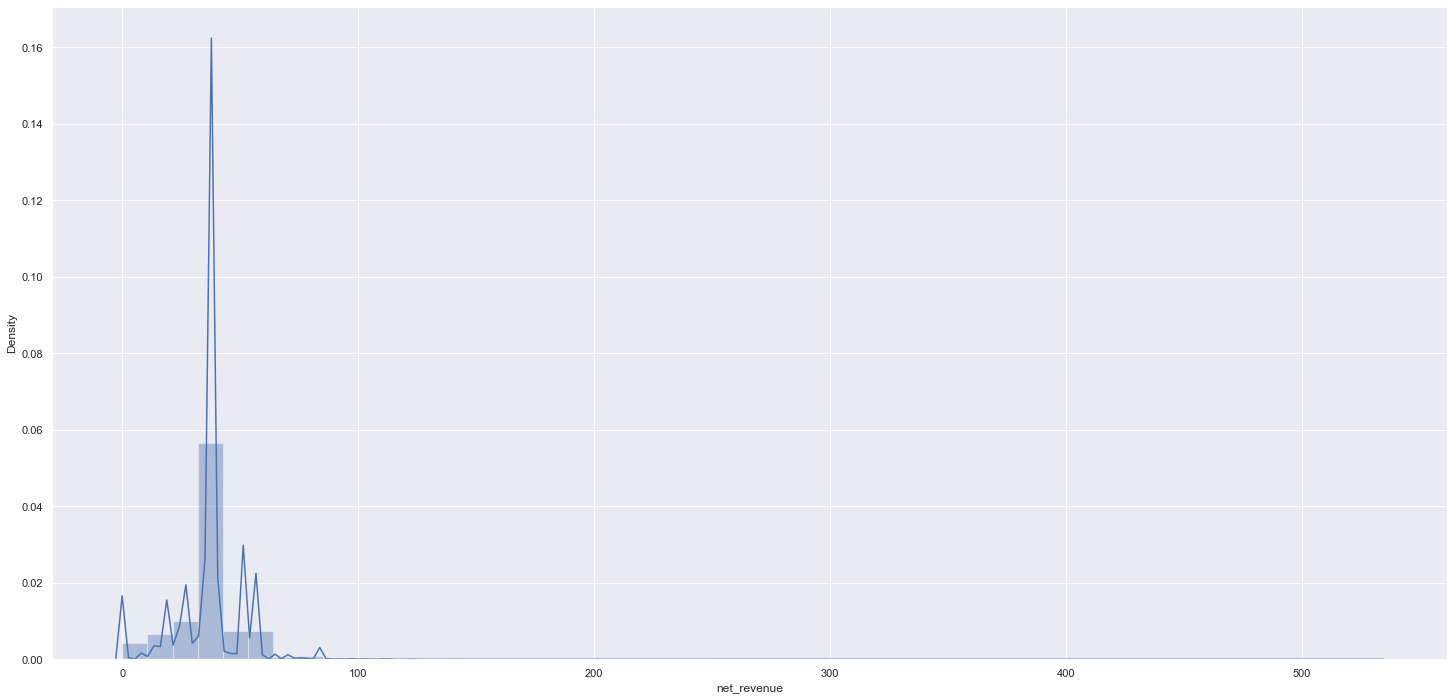

In [69]:
sns.distplot(df1['net_revenue'])

### 1.3.2 Categorical Attributes

In [74]:
categorical_attributes['boxes'] = numerical_attributes['boxes']
categorical_attributes = categorical_attributes.drop(['week'], axis=1)
categorical_attributes.apply(lambda x: x.unique().shape[0])

customer_acquisition_channel    2
boxes                           9
dtype: int64

<AxesSubplot:xlabel='boxes', ylabel='net_revenue'>

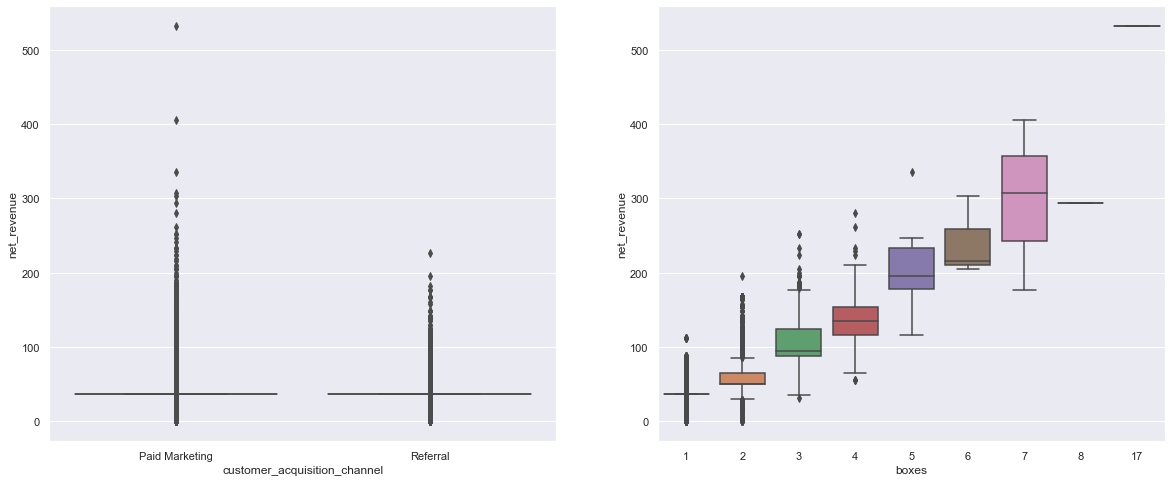

In [75]:
plt.figure(figsize = [20,8])
plt.subplot(1,2,1)
sns.boxplot(x='customer_acquisition_channel' , y= 'net_revenue' , data= df1)

plt.subplot(1,2,2)
sns.boxplot(x='boxes' , y= 'net_revenue' , data= df1)



Obs:
- Ao comparar os tipos de canal para aquisição dos clientes é perceptível que o marketing pago tem levemente uma distribuição mais favorecida para receita líquida que o canal de referências. Mas vale ressaltar que isso vale apenas para pontos extremos (Outliers), a média são equivalentes entre os dois tipos de acordo com o boxplot.

- O Box 7 tem uma melhor distribuição quando comparado com os demais boxes. Além de não apresentar outliers, a média está acima da mediana, então considera-se que temos um bom desempenho de arrecadação de receita líquida para esse box.

# 2.0 Feature Engineering

In [76]:
df2 = df1.copy()

## 2.1 Mind Map Hypothesis